
# CIFAR-10 Image Classification + Real-time Webcam Prediction
Welcome to the CIFAR-10 computer vision project! This notebook trains a CNN to classify images from the CIFAR-10 dataset and performs real-time prediction using your webcam.

**Dataset**: 60,000 32x32 color images in 10 classes  
**Goal**: Build a model and use it for live classification via webcam.


In [2]:

# !pip install tensorflow opencv-python matplotlib seaborn scikit-learn pillow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Set seed for reproducibility(important for unbiased results)
np.random.seed(42)
tf.random.set_seed(42)

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1] for better training
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


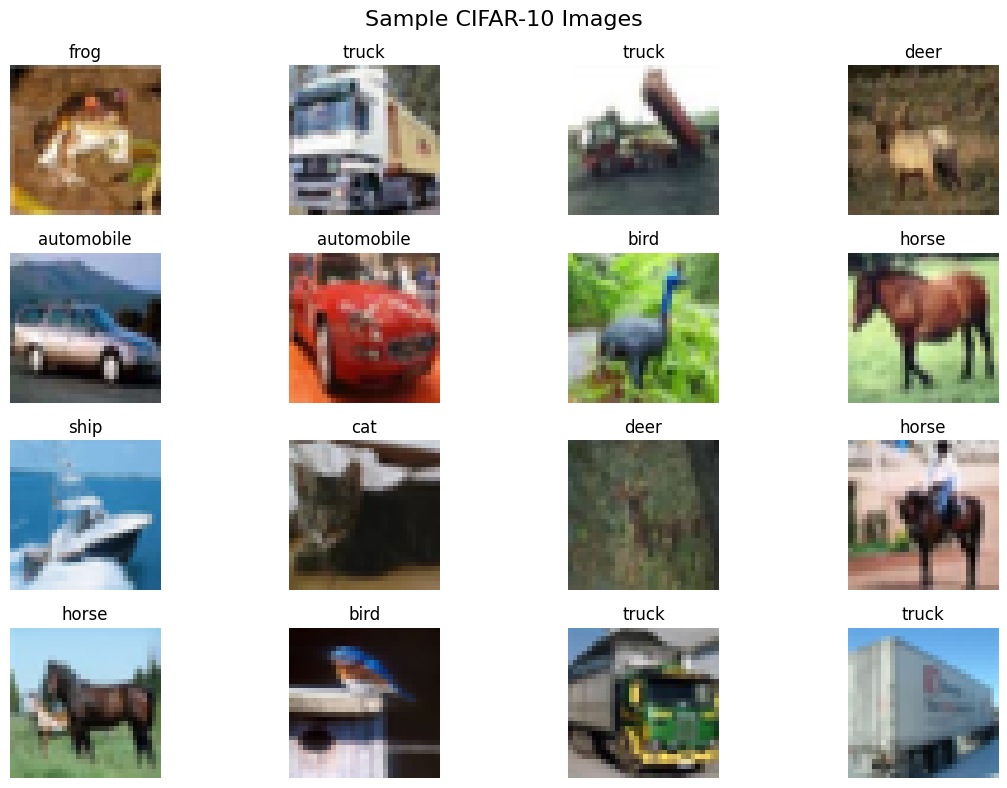

In [4]:

plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')
plt.suptitle("Sample CIFAR-10 Images", fontsize=16)
plt.tight_layout()
plt.show()


In [5]:

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737,834 (2.81 MB)

 Trainable params: 736,362 (2.81 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-4)
]

history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=32),
    epochs=25,
    validation_data=(x_test, y_test_cat),
    callbacks=callbacks
)


Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 95s 56ms/step - accuracy: 0.2914 - loss: 2.2706 - top_k_categorical_accuracy: 0.8034 - val_accuracy: 0.4481 - val_loss: 1.5998 - val_top_k_categorical_accuracy: 0.9151 - learning_rate: 0.0010
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.4906 - loss: 1.4189 - top_k_categorical_accuracy: 0.9261 - val_accuracy: 0.5216 - val_loss: 1.4353 - val_top_k_categorical_accuracy: 0.9483 - learning_rate: 0.0010
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.5605 - loss: 1.2460 - top_k_categorical_accuracy: 0.9434 - val_accuracy: 0.4983 - val_loss: 1.6634 - val_top_k_categorical_accuracy: 0.9175 - learning_rate: 0.0010
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 119ms/step - accuracy: 0.6045 - loss: 1.1242 - top_k_categorical_accuracy: 0.9566 - val_accuracy: 0.6850 - val_loss: 0.9005 - val_top_k_categorical_accuracy: 0.9762 - learning_rate: 0.0010
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - acc

In [7]:

# Accuracy
test_loss, test_acc, top_k = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Top-K Accuracy: {top_k:.4f}")

# Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


Test Accuracy: 0.7977
Top-K Accuracy: 0.9895
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.89      0.94      0.91      1000
        bird       0.76      0.67      0.71      1000
         cat       0.78      0.55      0.64      1000
        deer       0.78      0.76      0.77      1000
         dog       0.78      0.67      0.72      1000
        frog       0.60      0.96      0.74      1000
       horse       0.88      0.83      0.85      1000
        ship       0.90      0.89      0.90      1000
       truck       0.87      0.90      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



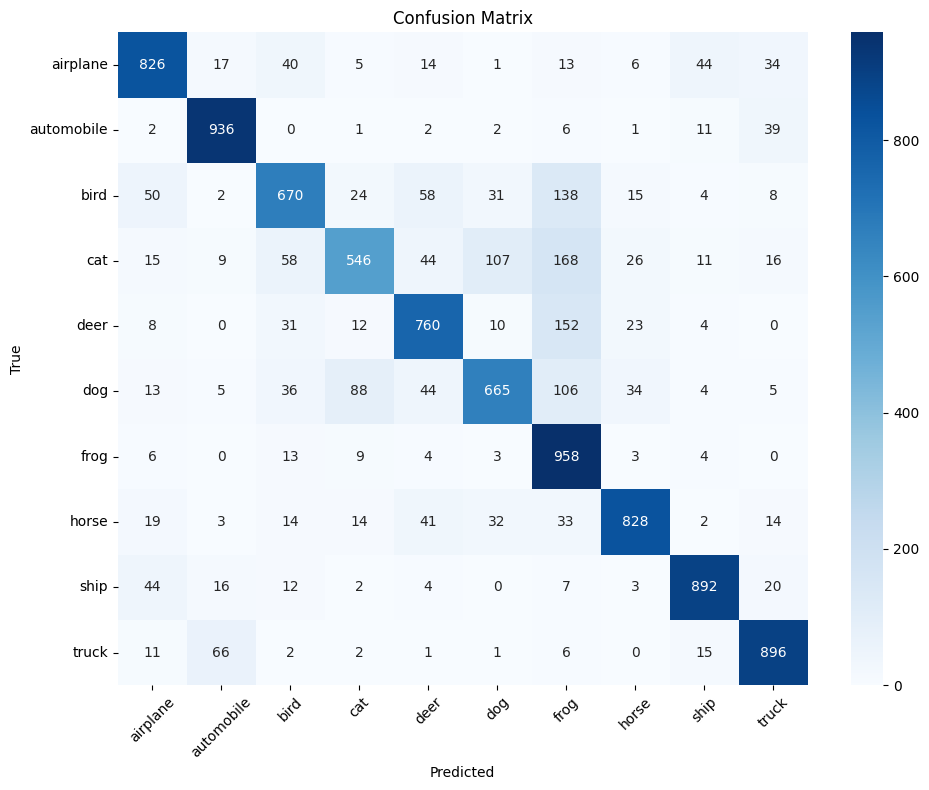

In [8]:

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


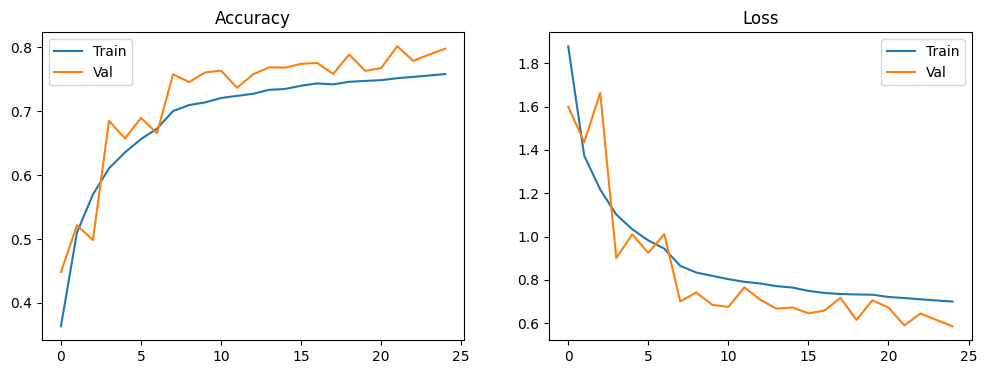

In [9]:

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()


In [10]:

def predict_image(image):
    if image.shape != (32, 32, 3):
        image = cv2.resize(image, (32, 32))
    img = image.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img, verbose=0)[0]
    top_idx = np.argmax(preds)
    return class_names[top_idx], preds[top_idx], preds

def webcam_prediction():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Webcam not accessible")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        h, w = frame.shape[:2]
        center = frame[h//4:h//4*3, w//4:w//4*3]
        label, conf, full_pred = predict_image(center)

        cv2.rectangle(frame, (w//4, h//4), (w//4*3, h//4*3), (0,255,0), 2)
        cv2.putText(frame, f"{label} ({conf:.2%})", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        cv2.imshow('CIFAR-10 Prediction', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [11]:
# from IPython.display import display
# import ipywidgets as widgets
# from PIL import Image

# upload_btn = widgets.FileUpload(accept='.jpg,.png,.jpeg', multiple=False)
# display(upload_btn)

In [12]:
# import io



# def predict_uploaded_image(upload_widget):
#     if not upload_widget.value:
#         print("No file uploaded.")
#         return

#     # Access the uploaded file from the tuple
#     uploaded_file = upload_widget.value[0]  # first file
#     content = uploaded_file.content

#     img = Image.open(io.BytesIO(content)).convert('RGB')
#     img = img.resize((32, 32))
    
#     img_array = np.array(img).astype('float32') / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     prediction = model.predict(img_array, verbose=0)[0]
#     predicted_label = class_names[np.argmax(prediction)]
    
#     plt.imshow(img)
#     plt.title(f"Prediction: {predicted_label} ({np.max(prediction):.2%})")
#     plt.axis('off')
#     plt.show()

# predict_uploaded_image(upload_btn)


In [13]:

#Run this cell to start webcam prediction (press 'q' to quit)
webcam_prediction()


In [14]:

# Save model
model.save("cifar10_model.h5")


In [15]:

# Load model
model = keras.models.load_model("cifar10_model.h5")
